<a href="https://colab.research.google.com/github/martharegina/machinelearning/blob/main/lendingclub_oc_pb_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils import resample
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Preprocessing

In [2]:
# Load dataset

object_cols = [
    'annual_inc',
    'dti',
    'fico_range_low',
    'fico_range_high',
    'emp_length',
    'revol_util',
    'total_acc',
    'open_acc',
    'delinq_2yrs',
    'loan_amnt',
    'installment',
    'term',
    'int_rate',
    'purpose',
    'application_type',
    'home_ownership',
    'issue_d'
]

data = pd.read_csv(
    '/content/accepted_2007_to_2018Q4.csv.gz',
    compression='gzip',
    usecols=object_cols,
    low_memory=False)
data.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,issue_d,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,open_acc,revol_util,total_acc,application_type
0,3600.0,36 months,13.99,123.03,10+ years,MORTGAGE,55000.0,Dec-2015,debt_consolidation,5.91,0.0,675.0,679.0,7.0,29.7,13.0,Individual
1,24700.0,36 months,11.99,820.28,10+ years,MORTGAGE,65000.0,Dec-2015,small_business,16.06,1.0,715.0,719.0,22.0,19.2,38.0,Individual
2,20000.0,60 months,10.78,432.66,10+ years,MORTGAGE,63000.0,Dec-2015,home_improvement,10.78,0.0,695.0,699.0,6.0,56.2,18.0,Joint App
3,35000.0,60 months,14.85,829.90,10+ years,MORTGAGE,110000.0,Dec-2015,debt_consolidation,17.06,0.0,785.0,789.0,13.0,11.6,17.0,Individual
4,10400.0,60 months,22.45,289.91,3 years,MORTGAGE,104433.0,Dec-2015,major_purchase,25.37,1.0,695.0,699.0,12.0,64.5,35.0,Individual


In [3]:
# Drop baris yang punya missing values
data = data.dropna(axis=0)
data.shape

(2111997, 17)

In [4]:
# Pilih data di tahun 2018 saja
data['issue_d'] = pd.to_datetime(data['issue_d'])
data = data[data['issue_d'].dt.year == 2018]

/tmp/ipython-input-2363021634.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['issue_d'] = pd.to_datetime(data['issue_d'])


In [5]:
# Ordinal encoding emp_length
emp_map = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}
data['emp_length'] = data['emp_length'].map(emp_map)

In [6]:
# Binary encoding term
data['term'] = data['term'].map({' 36 months': 0, ' 60 months': 1})

In [7]:
# Binary encoding application_type
data['joint_app'] = (data['application_type'] == 'Joint App').astype(int)
data = data.drop(columns=['application_type'], axis=1)

In [8]:
# Ordinal encoding home_ownership
home_map = {
    'RENT': 0,
    'MORTGAGE': 1,
    'OWN': 2,
    'ANY': 0
}

data['home_ownership'] = data['home_ownership'].map(home_map)

In [9]:
# Tambah kolom loan_to_income and installment_to_income
data['loan_to_income'] = data['loan_amnt'] / data['annual_inc']
data['installment_to_income'] = data['installment'] / data['annual_inc']

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 452656 entries, 421097 to 1611876
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   loan_amnt              452656 non-null  float64       
 1   term                   452656 non-null  int64         
 2   int_rate               452656 non-null  float64       
 3   installment            452656 non-null  float64       
 4   emp_length             452656 non-null  int64         
 5   home_ownership         452656 non-null  int64         
 6   annual_inc             452656 non-null  float64       
 7   issue_d                452656 non-null  datetime64[ns]
 8   purpose                452656 non-null  object        
 9   dti                    452656 non-null  float64       
 10  delinq_2yrs            452656 non-null  float64       
 11  fico_range_low         452656 non-null  float64       
 12  fico_range_high        452656 non-null  flo

# Overconfidence

In [11]:
features_oc = [
    'loan_to_income',
    'installment_to_income',
    'dti',
    'fico_range_low',
    'revol_util',
    'emp_length',
    'delinq_2yrs'
]

In [12]:
np.isinf(data[features_oc]).sum()

,0
loan_to_income,1
installment_to_income,1
dti,0
fico_range_low,0
revol_util,0
emp_length,0
delinq_2yrs,0


In [13]:
data[features_oc] = data[features_oc].replace([np.inf, -np.inf], np.nan)

In [14]:
data_oc = data[features_oc].dropna()

In [15]:
X_oc = StandardScaler().fit_transform(data_oc)

In [16]:
# Pertimbangan jumlah cluster
X_sample = resample(X_oc, n_samples=50000, random_state=42)

sil = []
for k in range(2,7):
    km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=10000)
    labels = km.fit_predict(X_sample)
    sil.append(silhouette_score(X_sample, labels))

sil

[np.float64(0.23066879440483096),
 np.float64(0.24517169096146693),
 np.float64(0.2454923032154201),
 np.float64(0.2220594340807672),
 np.float64(0.2174725008257129)]

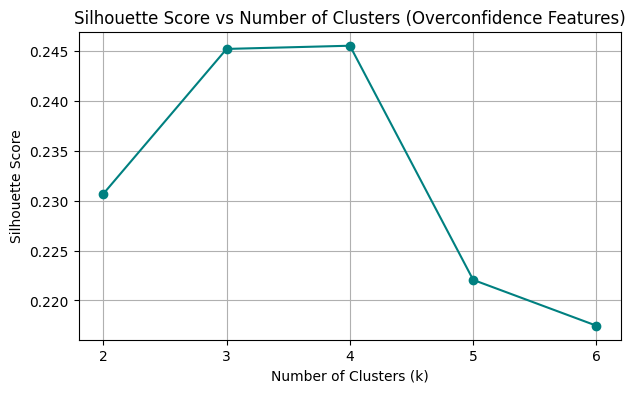

In [17]:
# Plot silhoutte scores

# Jumlah cluster yang diuji
k_values = range(2, 7)

# Silhouette scores dari notebook kamu
sil_scores = [
    0.23066879440483096,
    0.24517169096146693,
    0.2454923032154201,
    0.2220594340807672,
    0.2174725008257129
]

# Plot line chart
plt.figure(figsize=(7,4))
plt.plot(k_values, sil_scores, marker='o', linestyle='-', color='teal')
plt.xticks(k_values)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters (Overconfidence Features)")
plt.grid(True)
plt.show()

In [18]:
# Clustering k=3
kmeans = KMeans(n_clusters=3, random_state=42)
data_oc['OC_cluster'] = kmeans.fit_predict(X_oc)

In [19]:
# Buat cluster profile
cluster_profile_oc = data_oc.groupby('OC_cluster')[features_oc].mean()
cluster_profile_oc

,loan_to_income,installment_to_income,dti,fico_range_low,revol_util,emp_length,delinq_2yrs
OC_cluster,,,,,,,
0,0.241837,0.007318,18.943412,689.245762,51.315087,2.325430,0.238962
1,0.243044,0.006754,17.133798,750.555001,19.351624,6.114045,0.076123
2,0.264236,0.007900,21.102408,690.090418,55.752518,9.309386,0.346536


In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cluster_profile_oc_norm = pd.DataFrame(
    scaler.fit_transform(cluster_profile_oc),
    index=cluster_profile_oc.index,
    columns=cluster_profile_oc.columns
)

cluster_profile_oc_norm

,loan_to_income,installment_to_income,dti,fico_range_low,revol_util,emp_length,delinq_2yrs
OC_cluster,,,,,,,
0,0.000000,0.492407,0.455982,0.000000,0.878096,0.000000,0.602188
1,0.053889,0.000000,0.000000,1.000000,0.000000,0.542474,0.000000
2,1.000000,1.000000,1.000000,0.013777,1.000000,1.000000,1.000000


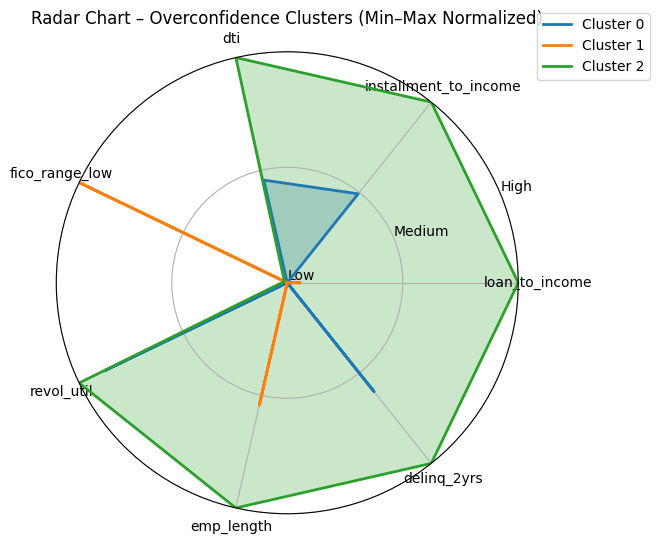

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def radar_chart(df, title):
    categories = df.columns.tolist()
    N = len(categories)

    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(7,6))
    ax = plt.subplot(111, polar=True)

    for cluster in df.index:
        values = df.loc[cluster].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=f'Cluster {cluster}')
        ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels(['Low', 'Medium', 'High'])

    plt.title(title, pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# OC radar
radar_chart(
    cluster_profile_oc_norm,
    "Radar Chart – Overconfidence Clusters (Min–Max Normalized)"
)

In [22]:
data_oc['overconfident'] = (data_oc['OC_cluster'] == 2).astype(int)

In [23]:
from scipy.stats import f_oneway

f_oneway(
    data_oc[data_oc.OC_cluster==0]['delinq_2yrs'],
    data_oc[data_oc.OC_cluster==1]['delinq_2yrs'],
    data_oc[data_oc.OC_cluster==2]['delinq_2yrs']
)

F_onewayResult(statistic=np.float64(4563.13930653073), pvalue=np.float64(0.0))

In [24]:
grand_mean = data_oc['delinq_2yrs'].mean()

ss_between = sum(
    len(g) * (g.mean() - grand_mean)**2
    for _, g in data_oc.groupby('OC_cluster')['delinq_2yrs']
)

ss_total = sum((data_oc['delinq_2yrs'] - grand_mean)**2)

eta_sq_oc = ss_between / ss_total
eta_sq_oc

np.float64(0.019763334560627392)

In [26]:
data_oc['ever_delinquent'] = (data_oc['delinq_2yrs'] > 0).astype(int)

# Pastikan y numeric
y = data_oc['ever_delinquent'].astype(int)

# Dummy cluster (cluster 0 jadi baseline)
X = pd.get_dummies(data_oc['OC_cluster'], drop_first=True)

# Pastikan semua numeric
X = X.astype(float)

# Tambahkan konstanta
X = sm.add_constant(X)

# Fit model
model_oc = sm.Logit(y, X).fit()
print(model_oc.summary())

Optimization terminated successfully.
         Current function value: 0.406478
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        ever_delinquent   No. Observations:               452655
Model:                          Logit   Df Residuals:                   452652
Method:                           MLE   Df Model:                            2
Date:                Mon, 02 Feb 2026   Pseudo R-squ.:                 0.03126
Time:                        10:48:13   Log-Likelihood:            -1.8399e+05
converged:                       True   LL-Null:                   -1.8993e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6795      0.007   -253.343      0.000      -1.693      -1.667
1             -0.9952      0.

In [27]:
np.exp(model_oc.params)

,0
const,0.186462
1,0.369663
2,1.365843


In [28]:
from scipy.stats import f_oneway

oc_fstats = []

for f in features_oc:
    groups = [
        data_oc[data_oc.OC_cluster == k][f]
        for k in sorted(data_oc.OC_cluster.unique())
    ]

    F, p = f_oneway(*groups)

    oc_fstats.append((f, F, p))

oc_fstats_df = pd.DataFrame(
    oc_fstats,
    columns=['feature', 'F_stat', 'p_value']
).sort_values('F_stat', ascending=False)

oc_fstats_df

,feature,F_stat,p_value
5,emp_length,392407.466457,0.000000
3,fico_range_low,306653.934870,0.000000
4,revol_util,136402.820079,0.000000
6,delinq_2yrs,4563.139307,0.000000
2,dti,1939.900568,0.000000
1,installment_to_income,6.010247,0.002454
0,loan_to_income,3.493487,0.030396


# Present Bias

In [29]:
features_pb = [
    'term',
    'installment_to_income',
    'int_rate',
    'loan_to_income',
    'delinq_2yrs'
]

In [30]:
np.isinf(data[features_pb]).sum()

,0
term,0
installment_to_income,0
int_rate,0
loan_to_income,0
delinq_2yrs,0


In [31]:
data[features_pb] = data[features_pb].replace([np.inf, -np.inf], np.nan)

In [32]:
data_pb = data[features_pb].dropna()

In [33]:
X_pb = StandardScaler().fit_transform(data_pb[features_pb])

In [34]:
# Pertimbangan jumlah cluster
X_sample = resample(X_pb, n_samples=50000, random_state=42)

sil = []
for k in range(2,7):
    km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=10000)
    labels = km.fit_predict(X_sample)
    sil.append(silhouette_score(X_sample, labels))

sil

[np.float64(0.5553044539941017),
 np.float64(0.5377778834493265),
 np.float64(0.5329255776063355),
 np.float64(0.49797730363432413),
 np.float64(0.45513883340661365)]

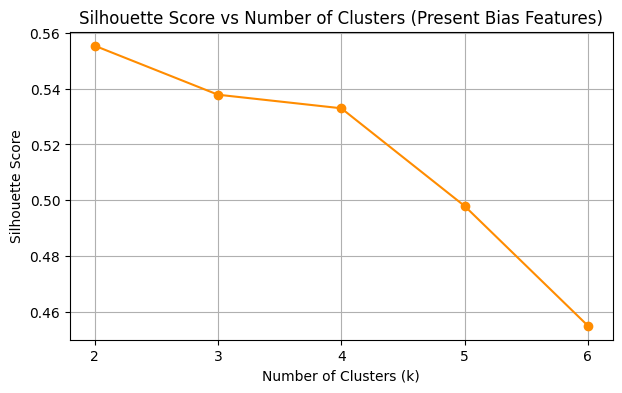

In [35]:
# Jumlah cluster yang diuji
k_values = range(2, 7)

# Silhouette scores dari notebook kamu (Present Bias)
sil_scores_pb = [
    0.5553044539941017,
    0.5377778834493265,
    0.5329255776063355,
    0.49797730363432413,
    0.45513883340661365
]

# Plot line chart
plt.figure(figsize=(7,4))
plt.plot(k_values, sil_scores_pb, marker='o', linestyle='-', color='darkorange')
plt.xticks(k_values)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters (Present Bias Features)")
plt.grid(True)
plt.show()

In [36]:
# Clustering k=3
kmeans = KMeans(n_clusters=2, random_state=42)
data_pb['PB_cluster'] = kmeans.fit_predict(X_pb)

In [37]:
# Buat cluster profile
cluster_profile_pb = data_pb.groupby('PB_cluster')[features_pb].mean()
cluster_profile_pb

,term,installment_to_income,int_rate,loan_to_income,delinq_2yrs
PB_cluster,,,,,
0,0.998921,0.008753,15.154950,0.352625,0.209908
1,0.000000,0.006751,11.601902,0.204098,0.242942


In [38]:
scaler = MinMaxScaler()
cluster_profile_pb_norm = pd.DataFrame(
    scaler.fit_transform(cluster_profile_pb),
    index=cluster_profile_pb.index,
    columns=cluster_profile_pb.columns
)

cluster_profile_pb_norm

,term,installment_to_income,int_rate,loan_to_income,delinq_2yrs
PB_cluster,,,,,
0,1.0,1.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0


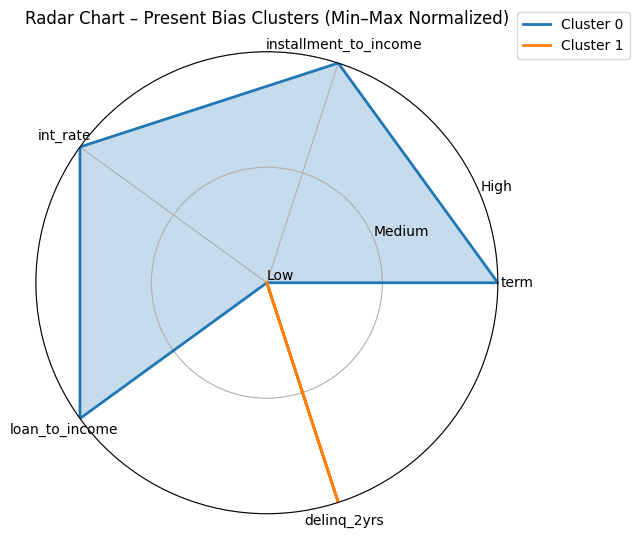

In [39]:
# PB radar
radar_chart(
    cluster_profile_pb_norm,
    "Radar Chart – Present Bias Clusters (Min–Max Normalized)"
)

In [40]:
data_pb['present_biased'] = (data_pb['PB_cluster'] == 0).astype(int)

In [41]:
from scipy.stats import f_oneway

f_oneway(
    data_pb[data_pb.PB_cluster==0]['delinq_2yrs'],
    data_pb[data_pb.PB_cluster==1]['delinq_2yrs']
)

F_onewayResult(statistic=np.float64(186.64058397651104), pvalue=np.float64(1.754264583403895e-42))

In [42]:
# Grand mean
grand_mean_pb = data_pb['delinq_2yrs'].mean()

# SS between
ss_between_pb = sum(
    len(g) * (g.mean() - grand_mean_pb)**2
    for _, g in data_pb.groupby('PB_cluster')['delinq_2yrs']
)

# SS total
ss_total_pb = sum((data_pb['delinq_2yrs'] - grand_mean_pb)**2)

eta_sq_pb = ss_between_pb / ss_total_pb
eta_sq_pb

np.float64(0.0004121560200334959)

In [43]:
data_pb['ever_delinquent'] = (data_pb['delinq_2yrs'] > 0).astype(int)

import statsmodels.api as sm

y = data_pb['ever_delinquent']

X = data_pb[['PB_cluster']].astype(float)
X = sm.add_constant(X)

model_pb = sm.Logit(y, X).fit()
print(model_pb.summary())

Optimization terminated successfully.
         Current function value: 0.419320
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        ever_delinquent   No. Observations:               452655
Model:                          Logit   Df Residuals:                   452653
Method:                           MLE   Df Model:                            1
Date:                Mon, 02 Feb 2026   Pseudo R-squ.:               0.0006566
Time:                        11:00:31   Log-Likelihood:            -1.8981e+05
converged:                       True   LL-Null:                   -1.8993e+05
Covariance Type:            nonrobust   LLR p-value:                 3.472e-56
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8504      0.008   -237.154      0.000      -1.866      -1.835
PB_cluster     0.1449      0.

In [44]:
np.exp(model_pb.params)

,0
const,0.157177
PB_cluster,1.155961


In [45]:
from scipy.stats import ttest_ind

pb_tstats = []

for f in features_pb:
    g0 = data_pb[data_pb.PB_cluster == 0][f]
    g1 = data_pb[data_pb.PB_cluster == 1][f]

    t_stat, p_val = ttest_ind(g0, g1, equal_var=False)

    pb_tstats.append((f, abs(t_stat), t_stat, p_val))

pb_tstats_df = pd.DataFrame(
    pb_tstats,
    columns=['feature', 'abs_t', 't_stat', 'p_value']
).sort_values('abs_t', ascending=False)

pb_tstats_df

,feature,abs_t,t_stat,p_value
0,term,11382.132021,11382.132021,0.000000e+00
2,int_rate,217.221950,217.221950,0.000000e+00
4,delinq_2yrs,14.131789,-14.131789,2.504001e-45
3,loan_to_income,11.651623,11.651623,2.327444e-31
1,installment_to_income,4.792024,4.792024,1.652757e-06
